In [1]:
import plotly
plotly.offline.init_notebook_mode(connected=True)

# Working with SAP HANA Using Python in an ExxonMobil Environment

SAP HANA is an in-memory relational database used to store all of our transactional data from SAP/STRIPES for use in analytics. It is also the location of various tables/views/models/reports that takes the raw information from SAP and turns them into data and metrics for the business organization. 

## Relational Databases

Relational databases are a form of data store that organizes the data into tables just like Excel worksheets just on much larger scales. Tables within HANA are organized first under a SCHEMA (think file folder). The default schema for all business users is ```_SYS_BIC``` which you see below. Under this schema you will then have a series of tables covering all aspects of the business. I believe at last count there were over 16,000 tables in the ExxonMobil instance.

SAP HANA like all relational databases have standardized ways to connect to the database and extract information. Generally to connect and extract information you will need:

* The database url and port number
* Computer instructions on what data to extract and how

### SAP HANA Database URL and Port Number

|Environment|Server Name|Port|
|:-|:-|:-|
|Production|Daldhph01.na.xom.com|30015|
|Acceptance|Hoedhah01.na.xom.com|30015|
|Development|Daldhdh01.na.xom.com|30015|

You can connect to SAP HANA using Analysis for Office in Excel, Tableau or in the examples following, using Python.

### Extracting Data

Most relational databases use a specialized computer programming language called *Sequential Query Language* (SQL) to instruct the database on what data to extract and how. What follows is just the bare basics on building these queries to extract data. You can do much more that just extract data though.

## Main Tables That I Use in SAP HANA

```
EVP : "_SYS_BIC"."xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW"

IFA : "_SYS_BIC"."xom.projects.IFA.Allocations_GLB.Reports/CA_IFA_GLB_ALLOC"

TDT : "_SYS_BIC"."xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM" 
    OR "_SYS_BIC"."xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM_OPTIM"

PHI_US : "_SYS_BIC"."xom.projects.TDT.FVC.reports/CA_FVC_PRICING_HEALTH_INDICATOR"

PHI_CA_MX : "_SYS_BIC"."xom.projects.TDT.FVC.reports/CA_FVC_CAN_MX_PRICING_HEALTH_INDICATOR"

Raw MRP : "_SYS_BIC"."xom.projects.TD_Foundation.DIC.reports/CA_YTPRICEARCREV_GLOBAL"

TM1 : "_SYS_BIC"."xom.projects.TDT.FVC.reports/CA_FVC_OICQP_ZOICQ"

VA : "_SYS_BIC"."xom.projects.TDT.VA_GLB.supply_vol.reports/CA_VA_SVOL_OPERATIONAL_VOLUMES"

MV : "_SYS_BIC"."xom.projects.TDT.FVC.reports/CA_FVC_MARKETVIEW_PRICES_FILL"

PMR : "_SYS_BIC"."xom.projects.RM.PMR_GLB.REPORTS/CA_RM_PMR_DOC_COMP_MV_REPORT"
```

## Steps to Creating a New HANA Query

1. Import hana_utils module of narwhal package
1. Determine table name
1. Determine which columns you want to extract
1. Build test query
1. Use the TOP 100 command to speed up testing (it will still be slow unless you add some filters though)
1. Figure out if there are any parameters
1. Apply any filters
1. Create any summary metrics
1. Apply any group by's if using summary metrics


### Determining Table Name

1. Look at examples from Tableau or Excel
1. Ask DAS
1. Search for table name

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import narwhal as nw
import pandas as pd
import plotly.graph_objects as go
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15, 7)
plt.style.use('ggplot')

# import matplotlib as mpl
# sorted(mpl.style.available)

from narwhal.get_data import hana_utils as hu 

up = nw.set_options(pass_file='../../user.json')
nw.set_proxy('iboss')

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

In [3]:
print(hu.default_queries.evp_volume)


SELECT "IBT_GEOG_LVL6", "IBT_FUNCTIONAL_LVL3", "GLOB_PROD_LVL3", "DATE_POSTING", "COMPANY_COUNTRY_NAME", sum("BARRELS_AT_60") AS "BARRELS_AT_60"
FROM "_SYS_BIC"."xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW"
WHERE ("COMPANY_COUNTRY_NAME" IN ('USA')) 
    AND ("MATERIAL_BALANCE_LVL3" = 'SALES')
    AND ("RECORD_VERSION" = 'Actuals') 
    AND ("IBT_FUNCTIONAL_LVL3" IN ('Retail MOSO', 'IW')) 
    AND ("EB_DRIVERS_LVL5" = 'External Sales vs Market') 
    AND ("FISCAL_YEAR" = 2020) 
    AND ("FISCAL_PERIOD_DESC" = 'Apr')
GROUP BY "IBT_GEOG_LVL6", "IBT_FUNCTIONAL_LVL3", "GLOB_PROD_LVL3", "DATE_POSTING", "COMPANY_COUNTRY_NAME","BARRELS_AT_60"



In [4]:
hu.search_tables('PCAVRT')

,SCHEMA_NAME,VIEW_NAME,VIEW_OID,IS_UNICODE,IS_READ_ONLY,IS_DDL_ONLY,HAS_CHECK_OPTION,HAS_COLUMN_ALIASES,DEFINITION,COMMENTS,IS_COLUMN_VIEW,VIEW_TYPE,IS_TENANT_SHARED_METADATA,IS_VALID,HAS_STRUCTURED_PRIVILEGE_CHECK,HAS_MASKED_COLUMNS,HAS_PARAMETERS,HAS_ANONYMIZATION,HAS_CACHE,CACHE_RETENTION,CACHE_FILTER,IS_CACHE_FORCED,CREATE_TIME,TABLE_NAME,TABLE_OID,FIXED_PART_SIZE,IS_LOGGED,IS_SYSTEM_TABLE,IS_COLUMN_TABLE,TABLE_TYPE,IS_INSERT_ONLY,IS_TENANT_SHARED_DATA,SESSION_TYPE,IS_TEMPORARY,TEMPORARY_TABLE_TYPE,COMMIT_ACTION,IS_USER_DEFINED_TYPE,HAS_PRIMARY_KEY,PARTITION_SPEC,USES_EXTKEY,AUTO_MERGE_ON,USES_DIMFN_CACHE,IS_PUBLIC,AUTO_OPTIMIZE_COMPRESSION_ON,COMPRESSED_EXTKEY,HAS_TEXT_FIELDS,USES_QUEUE_TABLE,IS_PRELOAD,IS_PARTIAL_PRELOAD,UNLOAD_PRIORITY,HAS_SCHEMA_FLEXIBILITY,IS_REPLICA,IS_SERIES_TABLE,ROW_ORDER_TYPE,TEMPORAL_TYPE,PERSISTENT_MEMORY,HAS_RECORD_COMMIT_TIMESTAMP,IS_REPLICATION_LOG_ENABLED,NUMA_NODE_INDEXES,IS_MOVABLE,LOAD_UNIT
0,_SYS_BIC,xom.projects.TDT.FVC_GLB.UP.reports/CA_PCAVRT_BASE_SNAPSHOT,1184590947.00000,FALSE,TRUE,FALSE,FALSE,FALSE,None,CA_PCAVRT_BASE_SNAPSHOT,TRUE,CALC,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,NONE,0.00000,None,FALSE,2018-02-24 15:21:06.847,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,FALSE,TRUE,FALSE,FALSE,FALSE,None,PCA/VRT DS Earnings Global (Earnings & Values Platform),TRUE,CALC,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,NONE,0.00000,None,FALSE,2021-12-02 14:53:31.096,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,_SYS_BIC,xom.projects.TD_Foundation.DIC.reports/CA_PCAVRT_VBRP_NA,1284452802.00000,FALSE,TRUE,FALSE,FALSE,FALSE,None,CA_PCAVRT_VBRP_NA,TRUE,CALC,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,NONE,0.00000,None,FALSE,2018-04-25 14:46:51.205,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Determining Column Names

In [5]:
df = hu.get_columns('xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW')
df

,SCHEMA_NAME,VIEW_NAME,VIEW_OID,COLUMN_NAME,POSITION,DATA_TYPE_ID,DATA_TYPE_NAME,OFFSET,LENGTH,SCALE,IS_NULLABLE,DEFAULT_VALUE,COLLATION,COMMENTS,MAX_VALUE,MIN_VALUE,CS_DATA_TYPE_ID,CS_DATA_TYPE_NAME,DDIC_DATA_TYPE_ID,DDIC_DATA_TYPE_NAME,COMPRESSION_TYPE,INDEX_TYPE,COLUMN_ID,PRELOAD,GENERATED_ALWAYS_AS,HAS_SCHEMA_FLEXIBILITY,FUZZY_SEARCH_INDEX,FUZZY_SEARCH_MODE,MEMORY_THRESHOLD,LOAD_UNIT,GENERATION_TYPE,IS_CACHABLE,IS_CACHE_KEY,ROW_ORDER_POSITION,IS_HIDDEN,IS_MASKED,MASK_EXPRESSION,CLIENTSIDE_ENCRYPTION_STATUS,CLIENTSIDE_ENCRYPTION_COLUMN_KEY_ID,CLIENTSIDE_ENCRYPTION_MODE,PERSISTENT_MEMORY,NUMA_NODE_INDEXES,TABLE_NAME,TABLE_OID
0,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,ACCOUNT,63,-9,NVARCHAR,0,10,NaN,TRUE,None,None,Account,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3683268985,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
1,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,ACCOUNT_ASSIGNMENT_CODE,971,-9,NVARCHAR,0,50,NaN,TRUE,None,None,Account Assignment Code,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3683269893,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
2,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,ACCOUNT_BASE,1091,-9,NVARCHAR,0,6,NaN,TRUE,None,None,Account Base,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3683270013,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
3,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,ACCOUNT_CATEGORY_LVL1,988,-9,NVARCHAR,0,30,NaN,TRUE,None,None,Account Category Lvl1,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3683269910,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
4,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,ACCOUNT_CATEGORY_LVL2,989,-9,NVARCHAR,0,30,NaN,TRUE,None,None,Account Category Lvl2,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3683269911,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1181,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,VR_CLASS_LVL2_NO,188,-9,NVARCHAR,0,18,NaN,TRUE,None,None,VR Class Lvl2,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3683269110,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
1182,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,VR_CLASS_LVL3,191,-9,NVARCHAR,0,40,NaN,TRUE,None,None,VR Class Lvl3 Desc,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3683269113,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
1183,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,VR_CLASS_LVL3_NO,190,-9,NVARCHAR,0,18,NaN,TRUE,None,None,VR Class Lvl3,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3683269112,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
1184,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,VR_CLASS_LVL4,193,-9,NVARCHAR,0,40,NaN,TRUE,None,None,VR Class Lvl4 Desc,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3683269115,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN


In [6]:
df.COLUMN_NAME.sort_values().to_list()[0:10]

['ACCOUNT',
 'ACCOUNT_ASSIGNMENT_CODE',
 'ACCOUNT_BASE',
 'ACCOUNT_CATEGORY_LVL1',
 'ACCOUNT_CATEGORY_LVL2',
 'ACCOUNT_CONTROL_GROUP',
 'ACCOUNT_CONTROL_GROUP_DESC',
 'ACCOUNT_CONTROL_GROUP_FROM',
 'ACCOUNT_CONTROL_GROUP_TO',
 'ACCOUNT_DESC']

In [7]:
df[df.COLUMN_NAME.str.contains('DATE')]

,SCHEMA_NAME,VIEW_NAME,VIEW_OID,COLUMN_NAME,POSITION,DATA_TYPE_ID,DATA_TYPE_NAME,OFFSET,LENGTH,SCALE,IS_NULLABLE,DEFAULT_VALUE,COLLATION,COMMENTS,MAX_VALUE,MIN_VALUE,CS_DATA_TYPE_ID,CS_DATA_TYPE_NAME,DDIC_DATA_TYPE_ID,DDIC_DATA_TYPE_NAME,COMPRESSION_TYPE,INDEX_TYPE,COLUMN_ID,PRELOAD,GENERATED_ALWAYS_AS,HAS_SCHEMA_FLEXIBILITY,FUZZY_SEARCH_INDEX,FUZZY_SEARCH_MODE,MEMORY_THRESHOLD,LOAD_UNIT,GENERATION_TYPE,IS_CACHABLE,IS_CACHE_KEY,ROW_ORDER_POSITION,IS_HIDDEN,IS_MASKED,MASK_EXPRESSION,CLIENTSIDE_ENCRYPTION_STATUS,CLIENTSIDE_ENCRYPTION_COLUMN_KEY_ID,CLIENTSIDE_ENCRYPTION_MODE,PERSISTENT_MEMORY,NUMA_NODE_INDEXES,TABLE_NAME,TABLE_OID
34,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,ACTUAL_GI_DATE,1092,91,DATE,0,10,NaN,TRUE,None,None,Actual GI Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683270014,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
193,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,DATE_CURRENCY_TRANSLATION,501,91,DATE,0,10,NaN,TRUE,None,None,Currency Translation Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683269423,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
194,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,DATE_DOCUMENT,14,91,DATE,0,10,NaN,TRUE,None,None,Doc Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683268936,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
195,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,DATE_ENTERED_ON,11,91,DATE,0,10,NaN,TRUE,None,None,Entry Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683268933,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
196,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,DATE_POSTING,15,91,DATE,0,10,NaN,TRUE,None,None,Posting Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683268937,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
203,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,DELIVERY_DATE,1093,91,DATE,0,10,NaN,TRUE,None,None,Delivery Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683270015,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
557,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,IFA_DATE1,61,91,DATE,0,10,NaN,TRUE,None,None,Material Doc Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683268983,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
558,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,IFA_DATE2,62,91,DATE,0,10,NaN,TRUE,None,None,Material Doc Date Normalized,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683268984,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
1081,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,STRATEGY_CLOSE_DATE,1010,91,DATE,0,10,NaN,TRUE,None,None,Stragtegy Close date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683269932,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN


In [11]:
# !pip install dtale

In [12]:
# import dtale
# dtale.show(df)

In [13]:
hu.get_columns('xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW', 'DATE')

,SCHEMA_NAME,VIEW_NAME,VIEW_OID,COLUMN_NAME,POSITION,DATA_TYPE_ID,DATA_TYPE_NAME,OFFSET,LENGTH,SCALE,IS_NULLABLE,DEFAULT_VALUE,COLLATION,COMMENTS,MAX_VALUE,MIN_VALUE,CS_DATA_TYPE_ID,CS_DATA_TYPE_NAME,DDIC_DATA_TYPE_ID,DDIC_DATA_TYPE_NAME,COMPRESSION_TYPE,INDEX_TYPE,COLUMN_ID,PRELOAD,GENERATED_ALWAYS_AS,HAS_SCHEMA_FLEXIBILITY,FUZZY_SEARCH_INDEX,FUZZY_SEARCH_MODE,MEMORY_THRESHOLD,LOAD_UNIT,GENERATION_TYPE,IS_CACHABLE,IS_CACHE_KEY,ROW_ORDER_POSITION,IS_HIDDEN,IS_MASKED,MASK_EXPRESSION,CLIENTSIDE_ENCRYPTION_STATUS,CLIENTSIDE_ENCRYPTION_COLUMN_KEY_ID,CLIENTSIDE_ENCRYPTION_MODE,PERSISTENT_MEMORY,NUMA_NODE_INDEXES,TABLE_NAME,TABLE_OID
0,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,ACTUAL_GI_DATE,1092,91,DATE,0,10,None,TRUE,None,None,Actual GI Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683270014,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
1,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,DATE_CURRENCY_TRANSLATION,501,91,DATE,0,10,None,TRUE,None,None,Currency Translation Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683269423,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
2,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,DATE_DOCUMENT,14,91,DATE,0,10,None,TRUE,None,None,Doc Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683268936,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
3,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,DATE_ENTERED_ON,11,91,DATE,0,10,None,TRUE,None,None,Entry Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683268933,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
4,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,DATE_POSTING,15,91,DATE,0,10,None,TRUE,None,None,Posting Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683268937,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
5,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,DELIVERY_DATE,1093,91,DATE,0,10,None,TRUE,None,None,Delivery Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683270015,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
6,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,IFA_DATE1,61,91,DATE,0,10,None,TRUE,None,None,Material Doc Date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683268983,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
7,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,IFA_DATE2,62,91,DATE,0,10,None,TRUE,None,None,Material Doc Date Normalized,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683268984,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
8,_SYS_BIC,xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW,38116172.00000,STRATEGY_CLOSE_DATE,1010,91,DATE,0,10,None,TRUE,None,None,Stragtegy Close date,None,None,101,DAYDATE,0,INVALID,DEFAULT,FULL,3683269932,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN


In [14]:
sql = """
SELECT TOP 100 DATE_POSTING, PLANT, BARRELS_AT_60, COMPANY_COUNTRY_NAME, SOLDTO_NAME
FROM "_SYS_BIC"."xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW"
"""

In [15]:
df = hu.get_hana(sql)
df.head()

--- 19.98031783103943 seconds ---


,DATE_POSTING,PLANT,BARRELS_AT_60,COMPANY_COUNTRY_NAME,SOLDTO_NAME
0,2017-03-29,0G2I,0E-14,EMML,
1,2018-07-07,00BN,0E-14,USA,KELLEY WILLIAMSON CO
2,2018-07-16,01CS,0E-14,USA,VALERO MARKETING & SUPPLY LEF3862
3,2020-12-14,00QE,0E-14,USA,MAC'S CONVENIENCE STORES LLC
4,2020-03-03,02VM,0E-14,USA,HAYS CITY CORPORATION


### Figure out if there are any parameters

In [16]:
hu.get_parameters("xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW")

,,,ORDER,NAME,DESCRIPTION,SCHEMA_NAME,QUALIFIED_NAME,ORIGINAL_SCHEMA,COLUMN_TYPE,COLUMN_TYPE_D,COLUMN_SQL_TYPE,VALUE_TYPE,VALUE_ATTRIBUTE,SELECTION_TYPE,MULTILINE,MANDATORY,DEFAULT_VALUE,VALUE_ENTITY,MODEL_ELEMENT_NAME,PLACEHOLDER_NAME
CATALOG_NAME,CUBE_NAME,VARIABLE_NAME,,,,,,,,,,,,,,,,,,


In [17]:
hu.get_column_values("xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW", "COMPANY_COUNTRY_NAME")

--- 18.039098501205444 seconds ---


,COMPANY_COUNTRY_NAME
0,
1,Americas HQ (AMHQ)
2,Argentina
3,Aruba
4,Belgium
5,Bermuda
6,Brazil
7,Canada
8,Chile
9,Colombia


### Apply any filters

In [18]:
sql = """
SELECT TOP 100 DATE_POSTING AS DATE, PLANT, BARRELS_AT_60, COMPANY_COUNTRY_NAME, SOLDTO_NAME
FROM "_SYS_BIC"."xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW"
WHERE COMPANY_COUNTRY_NAME LIKE '%USA%'
    AND ABS(BARRELS_AT_60) > 0
    AND MATERIAL_BALANCE_LVL3 = 'SALES'
    AND RECORD_VERSION = 'Actuals'
    AND IBT_FUNCTIONAL_LVL3 IN ('Retail MOSO', 'IW') 
    AND EB_DRIVERS_LVL5 = 'External Sales vs Market'
    AND FISCAL_YEAR >= 2021
"""

In [19]:
df = hu.get_hana(sql)
df.head()

--- 22.100157499313354 seconds ---


,DATE,PLANT,BARRELS_AT_60,COMPANY_COUNTRY_NAME,SOLDTO_NAME
0,2021-05-12,00WS,71.69000000000000,USA,WOODFORD OIL CO
1,2021-03-26,00BN,1960.73700000000000,USA,"U.S. VENTURE, INC"
2,2021-06-23,02O0,2042.49900000000000,USA,"GUTTMAN ENERGY, INC"
3,2021-10-31,00G7,1342.66600000000000,USA,SAMPSON BLADEN OIL CO INC
4,2021-05-12,00P7,1021.80900000000000,USA,ATLAS OIL COMPANY


### Create any summary metrics

You wil need to apply any group by's if using summary metrics

In [20]:
sql = """
SELECT COMPANY_COUNTRY_NAME
FROM "_SYS_BIC"."xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW"
GROUP BY COMPANY_COUNTRY_NAME
"""

In [21]:
df = hu.get_hana(sql)
df.head()

--- 7.517712831497192 seconds ---


,COMPANY_COUNTRY_NAME
0,
1,Americas HQ (AMHQ)
2,Argentina
3,Aruba
4,Belgium


In [22]:
sql = """
SELECT TOP 100 DATE_POSTING, PLANT, COMPANY_COUNTRY_NAME, SOLDTO_NAME,
    sum(BARRELS_AT_60) AS BARRELS
FROM "_SYS_BIC"."xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW"
WHERE COMPANY_COUNTRY_NAME LIKE '%USA%'
    AND ABS(BARRELS_AT_60) > 0
    AND MATERIAL_BALANCE_LVL3 = 'SALES'
    AND RECORD_VERSION = 'Actuals'
    AND IBT_FUNCTIONAL_LVL3 IN ('Retail MOSO', 'IW') 
    AND EB_DRIVERS_LVL5 = 'External Sales vs Market'
    AND FISCAL_YEAR >= 2021
GROUP BY DATE_POSTING, PLANT, COMPANY_COUNTRY_NAME, SOLDTO_NAME
"""

In [23]:
df = hu.get_hana(sql)
df.head()

--- 28.146713972091675 seconds ---


,DATE_POSTING,PLANT,COMPANY_COUNTRY_NAME,SOLDTO_NAME,BARRELS
0,2021-09-28,00Q4,USA,"SUNOCO, LLC",379.40500000000000
1,2021-03-11,02N2,USA,CIRCLE K STORES INC,503.40500000000000
2,2021-08-17,00C4,USA,LEHIGH GAS WHOLESALE LLC,628.14300000000000
3,2021-08-05,03DK,USA,S M O INC,1424.16800000000000
4,2021-12-11,00LQ,USA,SPRINGER-EUBANK COMPANY,398.69000000000000


### Sort if you want to...

In [24]:
sql = """
SELECT TOP 100 DATE_POSTING, PLANT, COMPANY_COUNTRY_NAME, SOLDTO_NAME,
    sum(BARRELS_AT_60) AS BARRELS
FROM "_SYS_BIC"."xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW"
WHERE COMPANY_COUNTRY_NAME LIKE '%USA%'
    AND ABS(BARRELS_AT_60) > 0
    AND MATERIAL_BALANCE_LVL3 = 'SALES'
    AND RECORD_VERSION = 'Actuals'
    AND IBT_FUNCTIONAL_LVL3 IN ('Retail MOSO', 'IW') 
    AND EB_DRIVERS_LVL5 = 'External Sales vs Market'
    AND FISCAL_YEAR >= 2021
    /*AND PLANT IS NOT NULL
    AND PLANT != ''*/
GROUP BY DATE_POSTING, PLANT, COMPANY_COUNTRY_NAME, SOLDTO_NAME
ORDER BY PLANT, DATE_POSTING, SOLDTO_NAME
"""

In [25]:
df = hu.get_hana(sql)
df.head()

--- 21.519118547439575 seconds ---


,DATE_POSTING,PLANT,COMPANY_COUNTRY_NAME,SOLDTO_NAME,BARRELS
0,2021-01-01,00A7,USA,AUTOMATED PETROLEUM & ENERGY,390.31000000000000
1,2021-01-01,00A7,USA,CIRCLE K STORES INC.,405.59500000000000
2,2021-01-01,00A7,USA,"DION FUELS, LLC",711.73900000000000
3,2021-01-01,00A7,USA,"GIANT OIL, INC.",352.66700000000000
4,2021-01-01,00A7,USA,"MACMILLAN OIL COMPANY, LLC",201.00000000000000


### Finally Run Full Query

This may take a while...

In [26]:
sql = """
SELECT DATE_POSTING, PLANT, COMPANY_COUNTRY_NAME, SOLDTO_NAME, GLOB_PROD_LVL3, GLOB_PROD_LVL4,
    sum(BARRELS_AT_60) AS BARRELS
FROM "_SYS_BIC"."xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW"
WHERE COMPANY_COUNTRY_NAME LIKE '%USA%'
    AND ABS(BARRELS_AT_60) > 0
    AND MATERIAL_BALANCE_LVL3 = 'SALES'
    AND RECORD_VERSION = 'Actuals'
    AND IBT_FUNCTIONAL_LVL3 IN ('Retail MOSO', 'IW') 
    AND EB_DRIVERS_LVL5 = 'External Sales vs Market'
    AND FISCAL_YEAR >= 2021
GROUP BY DATE_POSTING, PLANT, COMPANY_COUNTRY_NAME, SOLDTO_NAME, GLOB_PROD_LVL3, GLOB_PROD_LVL4
ORDER BY PLANT, DATE_POSTING
"""

In [27]:
df = hu.get_hana(sql)

--- 39.56800866127014 seconds ---


In [28]:
df

,DATE_POSTING,PLANT,COMPANY_COUNTRY_NAME,SOLDTO_NAME,GLOB_PROD_LVL3,GLOB_PROD_LVL4,BARRELS
0,2021-01-01,00A7,USA,ORION OIL LLC,Motor Gasoline,Regular,1329.54700000000000
1,2021-01-01,00A7,USA,"POWER PETROLEUM, INC.",Motor Gasoline,Premium,217.28700000000000
2,2021-01-01,00A7,USA,"SUNSHINE GASOLINE DISTRIBUTORS, INC",Motor Gasoline,Regular,5278.04800000000000
3,2021-01-01,00A7,USA,ORION OIL LLC,Motor Gasoline,Premium,212.73800000000000
4,2021-01-01,00A7,USA,AUTOMATED PETROLEUM & ENERGY,Motor Gasoline,Regular,314.57200000000000
...,...,...,...,...,...,...,...
917976,2021-12-14,03U7,USA,MEIJER DISTRIBUTION INC,Land Diesel,Regular ADO,48.02400000000000
917977,2021-12-15,03U7,USA,MEIJER DISTRIBUTION INC,Motor Gasoline,Regular,321.90500000000000
917978,2021-12-16,03U7,USA,MEIJER DISTRIBUTION INC,Land Diesel,Regular ADO,111.52400000000000
917979,2021-12-16,03U7,USA,MEIJER DISTRIBUTION INC,Motor Gasoline,Regular,854.85700000000000


In [29]:
df[df.SOLDTO_NAME.str.contains('CIRCLE')]

,DATE_POSTING,PLANT,COMPANY_COUNTRY_NAME,SOLDTO_NAME,GLOB_PROD_LVL3,GLOB_PROD_LVL4,BARRELS
6,2021-01-01,00A7,USA,CIRCLE K STORES INC.,Motor Gasoline,Premium,124.19000000000000
10,2021-01-01,00A7,USA,CIRCLE K STORES INC.,Motor Gasoline,Regular,281.40500000000000
29,2021-01-02,00A7,USA,CIRCLE K STORES INC.,Motor Gasoline,Regular,257.57200000000000
70,2021-01-03,00A7,USA,CIRCLE K STORES INC.,Motor Gasoline,Regular,519.80900000000000
88,2021-01-04,00A7,USA,CIRCLE K STORES INC.,Motor Gasoline,Premium,26.07100000000000
...,...,...,...,...,...,...,...
909509,2021-12-12,03QV,USA,CIRCLE K STORES INC,Motor Gasoline,Regular,182.00000000000000
909510,2021-12-12,03QV,USA,CIRCLE K STORES INC.,Motor Gasoline,Regular,174.88100000000000
909512,2021-12-12,03QV,USA,CIRCLE K STORES INC.,Land Diesel,Premium ADO,35.66700000000000
909517,2021-12-13,03QV,USA,CIRCLE K STORES INC.,Motor Gasoline,Premium,24.16700000000000


In [30]:
print(hu.default_queries.apv_values)


SELECT "PLANT_CODE", "MATERIAL_CODE", "SOLDTO_CODE", "DATE_DOCUMENT", "APV_COST", "VOLUME"
FROM "_SYS_BIC"."xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM" 
    ( 'PLACEHOLDER' = ('$$Currency$$', 'USD'), 
    'PLACEHOLDER' = ('$$Unit$$', 'UG6'), 
    'PLACEHOLDER' = ('$$Rate$$', 'USD/UG6') )
WHERE (
    CSHIPTO_COUNTRY_NAME = 'Canada'
    AND (EXTRACT(YEAR FROM TO_DATE("DATE_DOCUMENT")) >= 2020)
    AND ("GBU" IN ('RETAIL FUELS', 'WHOLESALE FUELS (I&W)'))
    AND ("VOLUME" <> 0))



In [31]:
print(hu.default_queries.evp_volume)


SELECT "IBT_GEOG_LVL6", "IBT_FUNCTIONAL_LVL3", "GLOB_PROD_LVL3", "DATE_POSTING", "COMPANY_COUNTRY_NAME", sum("BARRELS_AT_60") AS "BARRELS_AT_60"
FROM "_SYS_BIC"."xom.projects.TD_Foundation.Reports/CA_PCAVRT_GLOBAL_ROW"
WHERE ("COMPANY_COUNTRY_NAME" IN ('USA')) 
    AND ("MATERIAL_BALANCE_LVL3" = 'SALES')
    AND ("RECORD_VERSION" = 'Actuals') 
    AND ("IBT_FUNCTIONAL_LVL3" IN ('Retail MOSO', 'IW')) 
    AND ("EB_DRIVERS_LVL5" = 'External Sales vs Market') 
    AND ("FISCAL_YEAR" = 2020) 
    AND ("FISCAL_PERIOD_DESC" = 'Apr')
GROUP BY "IBT_GEOG_LVL6", "IBT_FUNCTIONAL_LVL3", "GLOB_PROD_LVL3", "DATE_POSTING", "COMPANY_COUNTRY_NAME","BARRELS_AT_60"



In [32]:
hu.get_hana(hu.default_queries.evp_volume)

--- 7.883827209472656 seconds ---


,IBT_GEOG_LVL6,IBT_FUNCTIONAL_LVL3,GLOB_PROD_LVL3,DATE_POSTING,COMPANY_COUNTRY_NAME,BARRELS_AT_60
0,USRM,Retail MOSO,Motor Gasoline,2020-04-26,USA,13750.47500000000000
1,USGC,IW,Land Diesel,2020-04-21,USA,97145.85700000000000
2,USMW,Retail MOSO,Land Diesel,2020-04-25,USA,5091.60200000000000
3,USNE,Retail MOSO,Land Diesel,2020-04-30,USA,8444.62200000000000
4,USGC,Retail MOSO,Motor Gasoline,2020-04-23,USA,271178.14300000000000
...,...,...,...,...,...,...
575,USRM,Retail MOSO,Land Diesel,2020-04-05,USA,5360.62000000000000
576,USMW,IW,Land Diesel,2020-04-28,USA,52167.15000000000000
577,USMW,IW,Motor Gasoline,2020-04-14,USA,22886.46100000000000
578,USGC,IW,Land Diesel,2020-04-05,USA,60910.85100000000000


In [33]:
print(hu.default_queries.phi_volume)


SELECT "GLOB_PROD_LVL3","DISTRIBUTION_CHANNEL","IFA_DATE1", sum("CA_BARRELS_AT_60") AS "CA_BARRELS_AT_60"
FROM "_SYS_BIC"."xom.projects.TDT.FVC.reports/CA_FVC_PRICING_HEALTH_INDICATOR"
WHERE (EXTRACT(YEAR FROM "IFA_DATE1") = 2020)
    AND (EXTRACT(MONTH FROM "IFA_DATE1") = 4) 
    AND ("GLOB_PROD_LVL3" IN ('Land Diesel', 'Motor Gasoline')) 
    AND ("CA_BARRELS_AT_60" <> 0)
GROUP BY "GLOB_PROD_LVL3","DISTRIBUTION_CHANNEL","IFA_DATE1","CA_BARRELS_AT_60"



## Another Example

In [34]:
hu.search_tables('TOP_INPUT')

,SCHEMA_NAME,VIEW_NAME,VIEW_OID,IS_UNICODE,IS_READ_ONLY,IS_DDL_ONLY,HAS_CHECK_OPTION,HAS_COLUMN_ALIASES,DEFINITION,COMMENTS,IS_COLUMN_VIEW,VIEW_TYPE,IS_TENANT_SHARED_METADATA,IS_VALID,HAS_STRUCTURED_PRIVILEGE_CHECK,HAS_MASKED_COLUMNS,HAS_PARAMETERS,HAS_ANONYMIZATION,HAS_CACHE,CACHE_RETENTION,CACHE_FILTER,IS_CACHE_FORCED,CREATE_TIME,TABLE_NAME,TABLE_OID,FIXED_PART_SIZE,IS_LOGGED,IS_SYSTEM_TABLE,IS_COLUMN_TABLE,TABLE_TYPE,IS_INSERT_ONLY,IS_TENANT_SHARED_DATA,SESSION_TYPE,IS_TEMPORARY,TEMPORARY_TABLE_TYPE,COMMIT_ACTION,IS_USER_DEFINED_TYPE,HAS_PRIMARY_KEY,PARTITION_SPEC,USES_EXTKEY,AUTO_MERGE_ON,USES_DIMFN_CACHE,IS_PUBLIC,AUTO_OPTIMIZE_COMPRESSION_ON,COMPRESSED_EXTKEY,HAS_TEXT_FIELDS,USES_QUEUE_TABLE,IS_PRELOAD,IS_PARTIAL_PRELOAD,UNLOAD_PRIORITY,HAS_SCHEMA_FLEXIBILITY,IS_REPLICA,IS_SERIES_TABLE,ROW_ORDER_TYPE,TEMPORAL_TYPE,PERSISTENT_MEMORY,HAS_RECORD_COMMIT_TIMESTAMP,IS_REPLICATION_LOG_ENABLED,NUMA_NODE_INDEXES,IS_MOVABLE,LOAD_UNIT
0,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,FALSE,TRUE,FALSE,FALSE,FALSE,None,GI Uplift Tool (CA_FVC_WC_TOP_INPUT_PARAM),TRUE,CALC,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,NONE,0.00000,None,FALSE,2021-12-16 12:40:15.222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM_OPTIM,3708312425.00000,FALSE,TRUE,FALSE,FALSE,FALSE,None,GI Uplift Tool – Optimized View,TRUE,CALC,TRUE,TRUE,FALSE,FALSE,TRUE,FALSE,NONE,0.00000,None,FALSE,2021-12-16 12:18:55.582,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
cols = hu.get_columns('xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM')

In [1]:
cols.head(10)

NameError: name 'cols' is not defined

In [37]:
# cols.to_excel('columns.xlsx')

In [38]:
cols[cols.COLUMN_NAME.str.contains('DATE')]

,SCHEMA_NAME,VIEW_NAME,VIEW_OID,COLUMN_NAME,POSITION,DATA_TYPE_ID,DATA_TYPE_NAME,OFFSET,LENGTH,SCALE,IS_NULLABLE,DEFAULT_VALUE,COLLATION,COMMENTS,MAX_VALUE,MIN_VALUE,CS_DATA_TYPE_ID,CS_DATA_TYPE_NAME,DDIC_DATA_TYPE_ID,DDIC_DATA_TYPE_NAME,COMPRESSION_TYPE,INDEX_TYPE,COLUMN_ID,PRELOAD,GENERATED_ALWAYS_AS,HAS_SCHEMA_FLEXIBILITY,FUZZY_SEARCH_INDEX,FUZZY_SEARCH_MODE,MEMORY_THRESHOLD,LOAD_UNIT,GENERATION_TYPE,IS_CACHABLE,IS_CACHE_KEY,ROW_ORDER_POSITION,IS_HIDDEN,IS_MASKED,MASK_EXPRESSION,CLIENTSIDE_ENCRYPTION_STATUS,CLIENTSIDE_ENCRYPTION_COLUMN_KEY_ID,CLIENTSIDE_ENCRYPTION_MODE,PERSISTENT_MEMORY,NUMA_NODE_INDEXES,TABLE_NAME,TABLE_OID
209,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,DATE_DOCUMENT,21,-9,NVARCHAR,0,8,NaN,TRUE,None,None,DATE_DOCUMENT,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565149,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
294,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,PRICING_DATE_FROM,199,-9,NVARCHAR,0,8,NaN,TRUE,None,None,PRICING_DATE_FROM,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565398,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
295,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,PRICING_DATE_TO,200,-9,NVARCHAR,0,8,NaN,TRUE,None,None,PRICING_DATE_TO,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565399,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN


In [39]:
hu.get_parameters('xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM')

ORDER  \
CATALOG_NAME                 CUBE_NAME                 VARIABLE_NAME          
xom.projects.TDT.FVC.reports CA_FVC_WC_TOP_INPUT_PARAM Currency           1   
                                                       Currency           2   
                                                       Currency           1   
                                                       Rate               1   
                                                       Rate               2   
                                                       Rate               3   
                                                       Rate               4   
                                                       Rate               5   
                                                       Rate               6   
                                                       Rate               7   
                                                       Rate               8   
                                                       Rate               9   
                                                       Rate              10   
                                                       Rate              11   
                                                       Rate              12   
                                                       Rate              13   
                                                       Rate              14   
                                                       Rate              15   
                                                       Rate              16   
                                                       Rate              17   
                                                       Rate              18   
                                                       Rate              19   
                                                       Rate              20   
                                                       Rate               3   
                                                       Unit               1   
                                                       Unit               2   
                                                       Unit               3   
                                                       Unit               4   
                                                       Unit               5   
                                                       Unit               2   

                                                                         NAME  \
CATALOG_NAME                 CUBE_NAME                 VARIABLE_NAME            
xom.projects.TDT.FVC.reports CA_FVC_WC_TOP_INPUT_PARAM Currency           CAD   
                                                       Currency           USD   
                                                       Currency           NaN   
                                                       Rate           USD/BB6   
                                                       Rate           USD/UG6   
                                                       Rate           USD/M15   
                                                       Rate           USD/L15   
                                                       Rate            USD/TO   
                                                       Rate           USC/BB6   
                                                       Rate           USC/UG6   
                                                       Rate           USC/M15   
                                                       Rate           USC/L15   
                                                       Rate            USC/TO   
                                                       Rate           CAD/BB6   
                                                       Rate           CAD/UG6   
                                                       Rate           CAD/M15   
                                                       Rate           CAD/L15   
  

In [40]:
?hu.get_parameters

Signature: hu.get_parameters(tbl_nm, schema='_SYS_BIC') -> pandas.core.frame.DataFrame
Docstring:
Function designed to get parameter names and values from SAP HANA. 

Parameters
----------
tbl_nm : str
    Name of table to get columns from. Can be a string used to search for a table/tables in HANA.
    To search using a table name part, use wild cards before, after or inside with the % charactor.
    i.e. %PRICING% will return any table with PRICING in the name. String is case sensitive.
schema : str
    Schema name for table in tbl_nm. Can be a string used to search for a table/tables in HANA.
    To search using a table name part, use wild cards before, after or inside with the % charactor.
    i.e. %SYS% will return any schema with 'SYS' in the name. String is case sensitive. By default '_SYS_BIC'

Notes
-----
    To use the return values from this function in an SAP HANA SQL query, use the PLACEHOLDER syntax as shown
    below, where the parameters are Currency, Unit and Rate:

   

In [41]:
cols[cols.COLUMN_NAME.str.contains('PLANT')]

,SCHEMA_NAME,VIEW_NAME,VIEW_OID,COLUMN_NAME,POSITION,DATA_TYPE_ID,DATA_TYPE_NAME,OFFSET,LENGTH,SCALE,IS_NULLABLE,DEFAULT_VALUE,COLLATION,COMMENTS,MAX_VALUE,MIN_VALUE,CS_DATA_TYPE_ID,CS_DATA_TYPE_NAME,DDIC_DATA_TYPE_ID,DDIC_DATA_TYPE_NAME,COMPRESSION_TYPE,INDEX_TYPE,COLUMN_ID,PRELOAD,GENERATED_ALWAYS_AS,HAS_SCHEMA_FLEXIBILITY,FUZZY_SEARCH_INDEX,FUZZY_SEARCH_MODE,MEMORY_THRESHOLD,LOAD_UNIT,GENERATION_TYPE,IS_CACHABLE,IS_CACHE_KEY,ROW_ORDER_POSITION,IS_HIDDEN,IS_MASKED,MASK_EXPRESSION,CLIENTSIDE_ENCRYPTION_STATUS,CLIENTSIDE_ENCRYPTION_COLUMN_KEY_ID,CLIENTSIDE_ENCRYPTION_MODE,PERSISTENT_MEMORY,NUMA_NODE_INDEXES,TABLE_NAME,TABLE_OID
214,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,FVC_CUST_BY_PLANT,22,-9,NVARCHAR,0,85,NaN,TRUE,None,None,FVC_CUST_BY_PLANT,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565150,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
227,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,FVC_PLANT_CODE,34,-9,NVARCHAR,0,4,NaN,TRUE,None,None,FVC_PLANT_CODE,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565162,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
228,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,FVC_PLANT_LATITUDE,119,8,DOUBLE,0,15,NaN,TRUE,None,None,FVC_PLANT_LATITUDE,None,None,100,DOUBLE,0,INVALID,DEFAULT,FULL,3708565247,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
229,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,FVC_PLANT_LONGITUDE,120,8,DOUBLE,0,15,NaN,TRUE,None,None,FVC_PLANT_LONGITUDE,None,None,100,DOUBLE,0,INVALID,DEFAULT,FULL,3708565248,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
230,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,FVC_PLANT_TEXT,35,-9,NVARCHAR,0,30,NaN,TRUE,None,None,FVC_PLANT_TEXT,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565163,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
231,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,FVC_PLANT_TEXT_CODE,36,-9,NVARCHAR,0,35,NaN,TRUE,None,None,FVC_PLANT_TEXT_CODE,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565164,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
284,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,PLANT_CODE,62,-9,NVARCHAR,0,4,NaN,TRUE,None,None,PLANT_CODE,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565190,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
285,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,PLANT_COUNTRY_CODE,63,-9,NVARCHAR,0,3,NaN,TRUE,None,None,PLANT_COUNTRY_CODE,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565191,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
286,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,PLANT_OWNER,64,-9,NVARCHAR,0,18,NaN,TRUE,None,None,PLANT_OWNER,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565192,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN
287,_SYS_BIC,xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM,2690378731.00000,PLANT_REGION,65,-9,NVARCHAR,0,3,NaN,TRUE,None,None,PLANT_REGION,None,None,83,STRING,0,INVALID,DEFAULT,FULL,3708565193,FALSE,None,FALSE,FALSE,None,None,None,None,FALSE,FALSE,None,FALSE,FALSE,None,None,None,None,None,None,NaN,NaN


In [42]:
print(hu.default_queries.tdt_vol_apv)


SELECT "PLANT_CODE", "MATERIAL_CODE", "SOLDTO_CODE", "DATE_DOCUMENT", "APV_COST", "VOLUME"
FROM "_SYS_BIC"."xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM" 
    ( 'PLACEHOLDER' = ('$$Currency$$', 'USD'), 
    'PLACEHOLDER' = ('$$Unit$$', 'UG6'), 
    'PLACEHOLDER' = ('$$Rate$$', 'USD/UG6') )
WHERE (
    CSHIPTO_COUNTRY_NAME ='Canada'
    AND (EXTRACT(YEAR FROM TO_DATE("DATE_DOCUMENT")) >= 2019)
    AND ("GBU" IN ('RETAIL FUELS', 'WHOLESALE FUELS (I&W)'))
    AND ("VOLUME" <> 0))



In [43]:
# new query here

In [44]:
sql = """
SELECT CAST(DATE_DOCUMENT AS DATE) AS DATE_DOCUMENT, COUNTRY_CODE, PLANT_TYPE_GROUP, PLANT_CODE, FVC_PRODUCT_TEXT, FVC_GRADE_TEXT, 
    sum(APV_COST) AS APV_COST, sum(VOLUME) AS VOLUME
FROM "_SYS_BIC"."xom.projects.TDT.FVC.reports/CA_FVC_WC_TOP_INPUT_PARAM"
    ( 'PLACEHOLDER' = ('$$Currency$$', 'USD'), 
        'PLACEHOLDER' = ('$$Unit$$', 'UG6'), 
        'PLACEHOLDER' = ('$$Rate$$', 'USC/UG6') )
WHERE PLANT_CODE != ''
    AND VOLUME IS NOT NULL
    AND abs(VOLUME ) > 0.01
    AND EXTRACT(YEAR FROM DATE_DOCUMENT) > 2020
    AND COUNTRY_CODE IN ('US', 'MX', 'CA')
GROUP BY DATE_DOCUMENT, COUNTRY_CODE, PLANT_TYPE_GROUP, PLANT_CODE, FVC_PRODUCT_TEXT, FVC_GRADE_TEXT
"""

In [45]:
df = hu.get_hana(sql)

--- 5.68562650680542 seconds ---


In [46]:
df['UNIT_APV'] = df.APV_COST/df.VOLUME*-1

In [47]:
df.PLANT_TYPE_GROUP.unique()

array(['Thruput', 'Terminal', 'Rack Purchase', 'Exchange', 'Pipeline',
       'Airport', 'Refinery', 'Intransit', 'Paper'], dtype=object)

<AxesSubplot:>

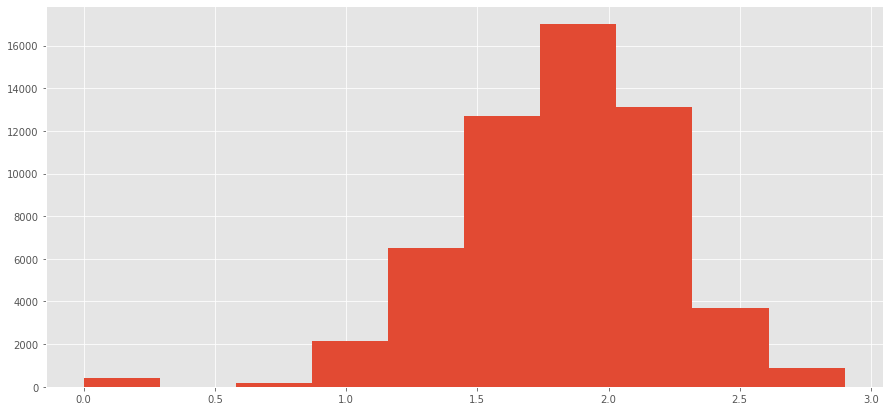

In [48]:
df[df.PLANT_TYPE_GROUP.isin(['Terminal','Airport', 'Refinery'])].UNIT_APV.hist()

In [2]:
df[(df.PLANT_TYPE_GROUP.isin(['Terminal','Airport', 'Refinery'])) & (df.UNIT_APV.abs() < 0.2)].head(10)

NameError: name 'df' is not defined

<AxesSubplot:xlabel='DATE_DOCUMENT'>

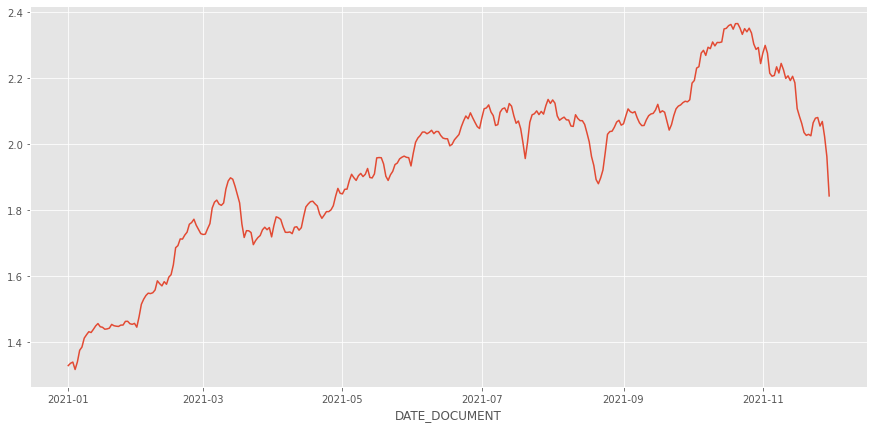

In [50]:
df.groupby(['DATE_DOCUMENT']).UNIT_APV.mean().plot()

In [51]:
tf = df.groupby(['DATE_DOCUMENT'])[['VOLUME','APV_COST']].sum()

In [52]:
tf['UNIT'] = tf.APV_COST/tf.VOLUME*-1

<AxesSubplot:xlabel='DATE_DOCUMENT'>

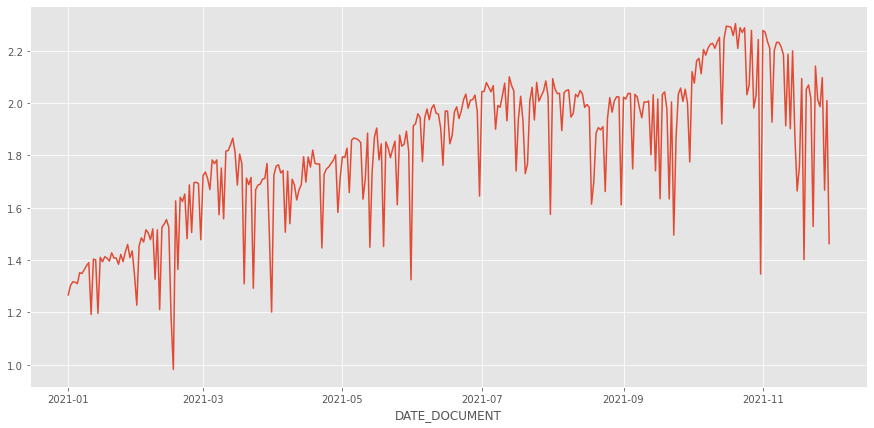

In [53]:
tf.UNIT.plot()